In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('data/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(60000, 785)

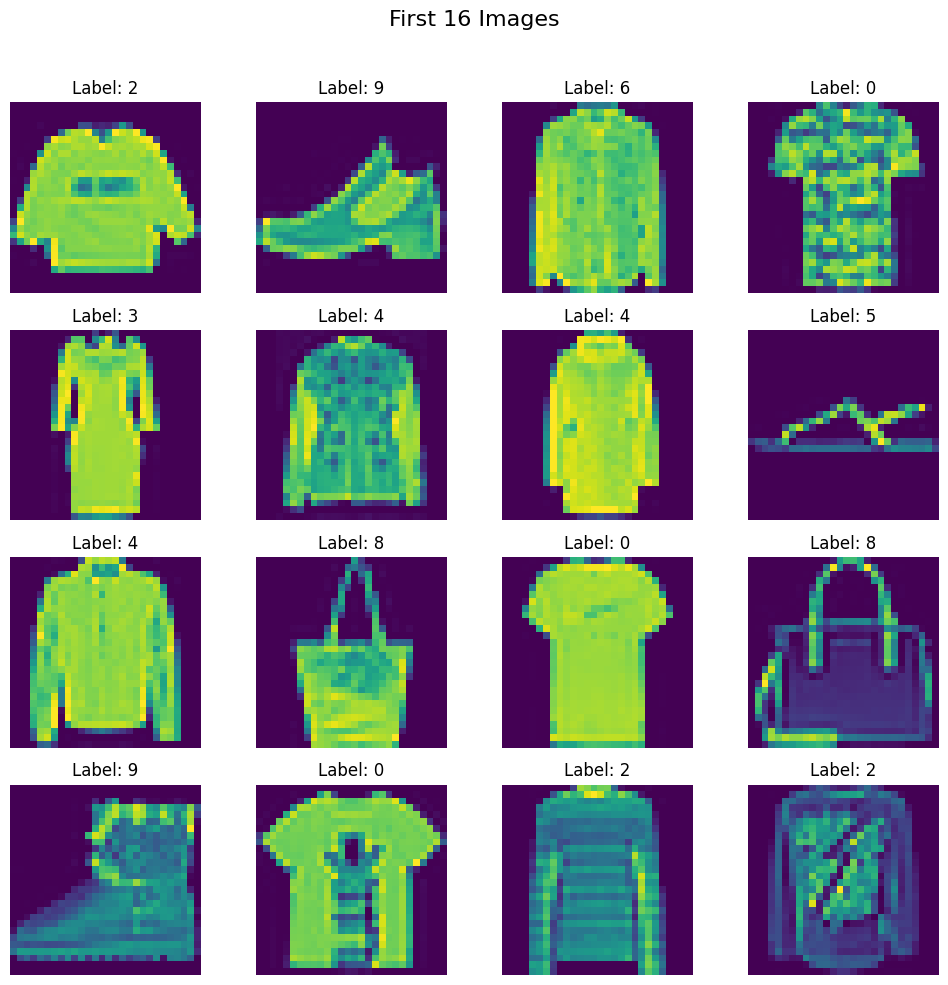

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [7]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [11]:
train_dataset = CustomDataset(X_train, y_train)

In [12]:
test_dataset = CustomDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [14]:
len(train_loader)

1500

In [ ]:
class MyNN(nn.Module):

  def __init__(self, input_features):

    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(input_features, 32, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
        
        
    self.classifier = nn.Sequential(    
        nn.Flatten(),
        nn.Linear(64*7*7, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(64, 10)

    )

  def forward(self, x):

    return self.model(x)


In [17]:
learning_rate = 0.1
epochs = 100

In [18]:
# instatiate the model
model = MyNN(X_train.shape[1])
model = model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.635193983823061
Epoch: 2 , Loss: 0.42952238681415716
Epoch: 3 , Loss: 0.3869724465931455
Epoch: 4 , Loss: 0.3589792065322399
Epoch: 5 , Loss: 0.337393187319239
Epoch: 6 , Loss: 0.32317901170005403
Epoch: 7 , Loss: 0.3076348851894339
Epoch: 8 , Loss: 0.29553309770176805
Epoch: 9 , Loss: 0.285360195821772
Epoch: 10 , Loss: 0.27353458426023525
Epoch: 11 , Loss: 0.26828947985668977
Epoch: 12 , Loss: 0.25840319122746586
Epoch: 13 , Loss: 0.2504708759797116
Epoch: 14 , Loss: 0.24585035655026635
Epoch: 15 , Loss: 0.24032416047155858
Epoch: 16 , Loss: 0.23308741933231553
Epoch: 17 , Loss: 0.22659470405305426
Epoch: 18 , Loss: 0.22024774242813389
Epoch: 19 , Loss: 0.21402468410755196
Epoch: 20 , Loss: 0.20909977698108803
Epoch: 21 , Loss: 0.2063814871435364
Epoch: 22 , Loss: 0.20201907060233254
Epoch: 23 , Loss: 0.1961098784810553
Epoch: 24 , Loss: 0.19319878923210004
Epoch: 25 , Loss: 0.18844192198850215
Epoch: 26 , Loss: 0.1847357962684085
Epoch: 27 , Loss: 0.18056066171700

In [20]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [21]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.883


In [22]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9790208333333333
